In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import astropy.units as u
from astropy.constants import G
G = G.to(u.pc * u.Msun**-1 * (u.km / u.s)**2)
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
import gala.units as gu

from gala.units import galactic
from gala.potential import NFWPotential
from gala.dynamics import PhaseSpacePosition, MockStream
from gala.integrate import LeapfrogIntegrator

from Gala_stream import run
from stream_track import unwrap, average_orbit


In [2]:
# Parameters

mass_halo = 1e12 * u.Msun
r_s = 10 * u.kpc

mass_plummer = 1e8 * u.Msun
r_plummer = 1 * u.kpc

time = 4 * u.Gyr
dt   = 1 * u.Myr

pos_p = [50, -50, 0] * u.kpc
vel_p = [0, -175, 0] * u.km/u.s

N  = 4000
dN = 1

orbit_pos_p, orbit_pos_N, leading_arg, trailing_arg = run(mass_halo, r_s, mass_plummer, r_plummer, time, dt, pos_p, vel_p, N, dN)

100%|██████████| 4000/4000 [00:41<00:00, 96.34it/s] 


In [45]:
n = 1000
reso = 500
x_mean_leading, y_mean_leading = average_orbit(orbit_pos_N, leading_arg, n, reso).forward()
x_mean_trailing, y_mean_trailing = average_orbit(orbit_pos_N, trailing_arg, n, reso).forward()


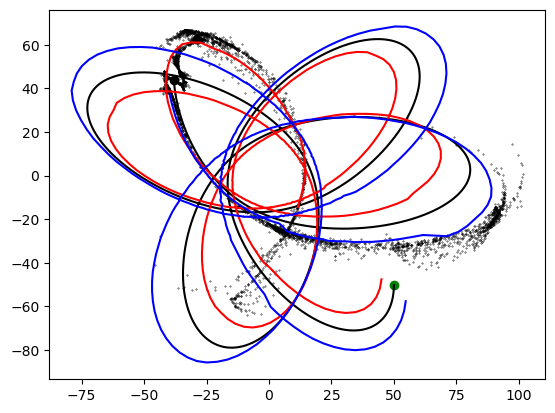

In [46]:
plt.scatter(orbit_pos_N[-1, :, 0], orbit_pos_N[-1, :, 1], s=0.1, c='k')
plt.scatter(orbit_pos_p[0, 0], orbit_pos_p[0, 1], c='g')
plt.scatter(orbit_pos_p[-1, 0], orbit_pos_p[-1, 1], c='k')
plt.plot(orbit_pos_p[:, 0], orbit_pos_p[:, 1], c='k')

crop = reso // 1
plt.plot(x_mean_leading[-crop:], y_mean_leading[-crop:], c='r')
plt.plot(x_mean_trailing[-crop:], y_mean_trailing[-crop:], c='b')

In [25]:
n = 11
arg = trailing_arg
keep_arg    = np.linspace(0, len(arg), n)
leading_idx = np.array(arg)[keep_arg.astype(int)[:-1]]

first = 1
x_leading = orbit_pos_N[first:,leading_idx, 0].T.value
y_leading = orbit_pos_N[first:,leading_idx, 1].T.value

a = np.sign(x_leading[0, 0])
b = np.sign(y_leading[0, 1] - y_leading[0, 0])

x_leading_corrected = a * x_leading
y_leading_corrected = b * y_leading 

r_leading_corrected     = np.sqrt(x_leading_corrected**2 + y_leading_corrected**2) 
theta_leading_corrected = np.arctan2(y_leading_corrected, x_leading_corrected)

arg_remove = np.array(np.where(r_leading_corrected == 0))
arg_keep   = np.array(np.where(r_leading_corrected != 0))

theta_leading_unwrapped = np.zeros(theta_leading_corrected.shape)
for i in range(n-1):
    theta_leading_unwrapped[i] = unwrap(theta_leading_corrected[i])
for i in range(n-2):
    if np.diag(theta_leading_unwrapped[:,leading_idx])[i+1] < np.diag(theta_leading_unwrapped[:,leading_idx])[i]:
        theta_leading_unwrapped[i+1:] += 2*np.pi

theta_0 = theta_leading_unwrapped[0,0]
theta_leading_unwrapped -= theta_0

In [26]:
def average_column(x,y, n_bins=101):
    xx = x.flatten()
    yy = y.flatten()

    arg_keep = np.array(np.where(yy != 0))[0]
    xx_keep  = xx[arg_keep]
    yy_keep  = yy[arg_keep]

    bins = np.linspace(xx[0], xx.max(), n_bins)

    yy_mean = []
    for index, i in enumerate(bins[:-1]):
        arg_bin = np.where( (i <= xx_keep) & (xx_keep <=bins[index+1]))[0]
        yy_mean.append( np.mean(yy_keep[arg_bin]) )
    yy_mean = np.array(yy_mean)
    xx_mean = bins[:-1] + np.diff(bins)/2

    return xx_mean, yy_mean

theta_mean, r_mean = average_column(theta_leading_unwrapped, r_leading_corrected)

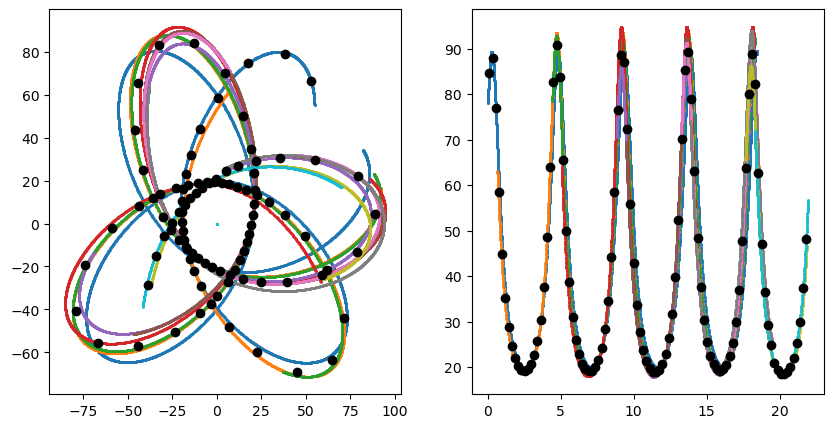

In [27]:
plt.figure(figsize=(10,5))
for i in range(n-1):
    plt.subplot(1,2,1)
    plt.scatter(x_leading_corrected[i], y_leading_corrected[i], s=1)
    plt.subplot(1,2,2)
    plt.scatter(theta_leading_unwrapped[i, leading_idx[i]:], r_leading_corrected[i, leading_idx[i]:], s=1)
plt.scatter(theta_mean, r_mean, c='k')
plt.subplot(1,2,1)
x_leading_mean = r_mean*np.cos(theta_mean+theta_0)
y_leading_mean = r_mean*np.sin(theta_mean+theta_0)
plt.scatter(x_leading_mean, y_leading_mean, c='k')

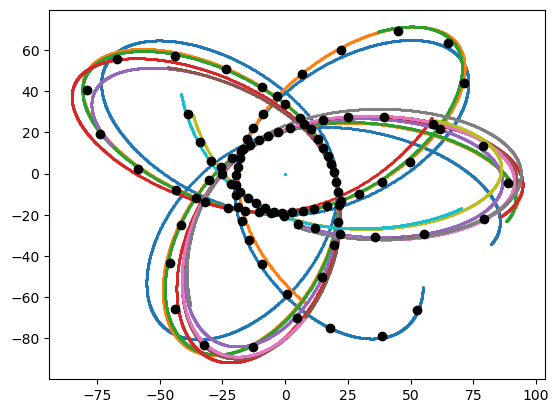

In [28]:
x_leading_final = x_leading_mean / a
y_leading_final = y_leading_mean / b

for i in range(n-1):
    plt.scatter(x_leading[i], y_leading[i], s=1)
plt.scatter(x_leading_final, y_leading_final, c='k')